# 7.4

In [0]:
import numpy as np
from scipy.stats import beta, binom, nbinom
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 7.16

Use importance sampling, drawing from Beta(a,b) for various values of a and b, to estimate the integral $\int_0^\pi\frac{dx}{x^3 + 2x + 3}$. Find values of a and b and sample size n that will give a standard error less than $10^{-3}$

First, we introduce a change in variables to write the integral from 0 to $\pi$, namely $\int_0^1\frac{\pi dy}{\pi^3y^3 + 2\pi y + 3}$.

In [0]:
def h(x):
  """ Definition of the integrand in 7.16 """
  return np.pi/(np.pi**3 * x**3 + 2 * np.pi * x + 3)

In [0]:
def calc_standard_error(h,f_X,draws):
  """ Calculates standard error given an h(x), f_X(x), and number of random draws."""
  kx = h(draws) / f_X(draws)
  y_hat = kx.mean()
  se = np.sqrt( ((kx - y_hat)**2).sum() / (len(draws) * (len(draws) - 1)))
  return se

We first seek a beta function which resembles $
h(x)$. We perform a grid search and print out viable candidates

In [0]:
ab = np.logspace(-5,5,num=20,base=2)
for a in ab:
  for b in ab:

    f_X = beta(a,b).pdf

    for n in np.logspace(1,5,10).astype(int):
      se = calc_standard_error(h,f_X, np.random.random(n))
      if se < 10 **-3:
        print(a,b,n,se)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in square
  """


0.1344613232775228 1.2001027195781027 100000 0.0009669327688506245
0.19365745528333192 0.8332620063985443 100000 0.0008812204996879651
0.19365745528333192 1.2001027195781027 100000 0.000680452008229209
0.27891447944038594 0.5785551186413598 100000 0.0008702013632408281
0.27891447944038594 0.8332620063985443 100000 0.0007077026331124883
0.27891447944038594 1.2001027195781027 35938 0.000817725592747766
0.27891447944038594 1.2001027195781027 100000 0.000492869830257639
0.4017056132834412 0.5785551186413598 100000 0.0007996089659684574
0.4017056132834412 0.8332620063985443 100000 0.000618744712898158
0.4017056132834412 1.2001027195781027 35938 0.0006556791601220848
0.4017056132834412 1.2001027195781027 100000 0.0003932252441234312
0.5785551186413598 0.5785551186413598 100000 0.0008466394761144092
0.5785551186413598 0.8332620063985443 100000 0.0006238038490810136
0.5785551186413598 1.2001027195781027 35938 0.0006391558586890204
0.5785551186413598 1.2001027195781027 100000 0.0003822429228068

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


We pick one of the viable choices from the list, plot the given beta distribution an return the standard error:

$a = .2789, b = 1.20, n = 50000$

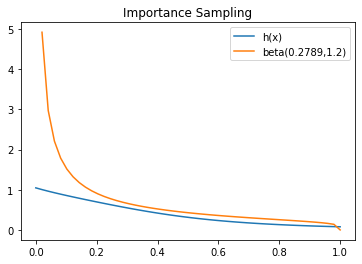

Standard Error: 0.0006988567775112641


In [0]:
a = .2789
b = 1.2
f_X = beta(a,b).pdf

x = np.linspace(0,1,50)
plt.plot(x,h(x), label="h(x)")
plt.plot(x,f_X(x),label="beta({},{})".format(a,b))
plt.legend()
plt.title("Importance Sampling")
plt.show()

print("Standard Error:", calc_standard_error(h,f_X,np.random.random(50000)))

##7.18

The c.d.f of a discrete distribution $F_X$ is ususally not invertible, so $F^{-1}(U)$ cannot be used for inversion sampling. Nevertheless, if $X$ is supported on a discrete set $A \subset \mathbb{R}$, then we can define $G(u) = \inf\{a \in A | u \leq F_X(a)\}$.

i.) Prove that if $U \sim Uniform(0,1)$, then the variable $Y = G(U)$ is a random variable with c.d.f. equal to $F_X$. This gives an algorithm for sampling from discrete distributions that we call *discrete inversion sampling*.

Proof: It is clear to see that Y is a random variable since G is simply a transformation on $U \sim Uniform(0,1)$.

Then by definition of c.d.f., $F_Y(a) = \sum_\limits{u \leq a, u\in \mathbb{R}}f_Y(u) = \sum_\limits{x \leq a, x \in A}f_X(x) = F_X(a)$

ii.) Implement discrete inversion sampling to sample from a $\text{Bernoulli}(p)$ distribution for arbitrary $p$. Use your method to draw 1000 times.

In [0]:
def inv_Bernoulli(p, n):
  """ Uses discrete inversion sampling to draw n times from X ~ Bernoulli(p) """
  # draw n times from U ~ Uniform(0,1)
  draws = np.random.random(n)

  # Transform Y = G(U) where Y has c.d.f. equal to X ~ Bernoulli(p)
  # Returns True if draw value <= p, False otherwise
  return draws <= p 

In [0]:
draws = inv_Bernoulli(.2,1000)

In [0]:
def inv_Binomial(n,p, num_draws):
  """ Uses discrete inversion sampling to draw num_draws times from X ~ Binomial(n,p) """
  # draw num_draws times from U ~ Uniform(0,1)
  draws = np.random.random(num_draws)

  # Transform Y = G(U) where Y has c.d.f. equal to X ~ Binomial(n,p)
  cdf = binom(n,p).cdf(np.arange(n+1))
  G_draw = [np.where(draw < cdf)[0][0] for draw in draws]
  return G_draw
  

In [0]:
import time

Bernoulli method: 0.02946162223815918
Binomial method: 0.003127574920654297


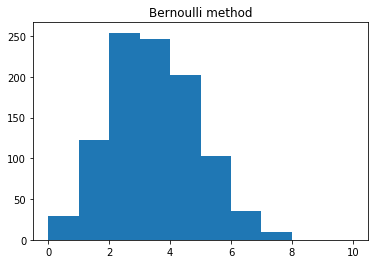

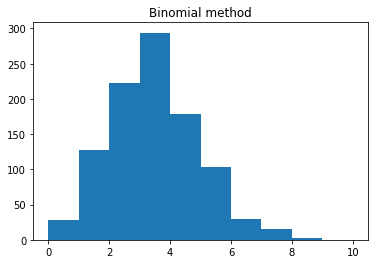

In [0]:
# time both methods
bernoulli_draws = []

start = time.time()
for _ in range(1000):   # Draw 1000 times
  bernoulli_draws.append(sum(inv_Bernoulli(.3,10)))
bernoulli_time = time.time() - start

start = time.time()
binom_draws = inv_Binomial(10,0.3,1000)
binomial_time = time.time() - start

print("Bernoulli method:",bernoulli_time)
print("Binomial method:", binomial_time)

plt.hist(bernoulli_draws, bins=np.arange(11))
plt.title("Bernoulli method")
plt.show()

plt.hist(binom_draws,bins=np.arange(11))
plt.title("Binomial method")
plt.show()

In my implementation, the binomial method is nearly ten times faster.

iv.) Use discrete inversion sampling to sample from a NegBin(k,p) distribution for arbitrary k and p. Draw 1000 times with k=5 and p=0.4, and plot a histogram of the results along the p.m.f. of the true distribution.

In [0]:
def inv_negbin(k,p,num_draws):
  """ Uses discrete inversion sampling to draw num_draws times from X ~ Binomial(n,p) """
  # draw num_draws times from U ~ Uniform(0,1)
  draws = np.random.random(num_draws)

  # Transform Y = G(U) where Y has c.d.f. equal to X ~ Binomial(n,p)
  
  nbincdf = nbinom(k,p).cdf
  cdf = [nbincdf(0)]
  def get_next(d):
    while d > cdf[-1]:
      cdf.append(nbincdf(len(cdf)))

    return np.where(d < cdf)[0][0]


  # G_draw = [np.where(draw < cdf)[0][0] for draw in draws]
  G_draw = [get_next(draw) for draw in draws]
  return G_draw

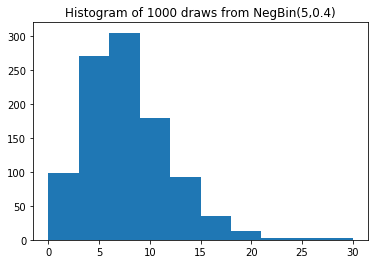

In [0]:
draws = inv_negbin(5,0.4,1000)
plt.hist(draws)
plt.title("Histogram of 1000 draws from NegBin(5,0.4)")
plt.show()

##7.19

Use rejection sampling to sample 1000 times from a distribution with p.d.f. $f_X(x) \propto x(1-x)e^x$ on [0,1]. Plot a histogram of the results, along with a plot of the p.d.f.

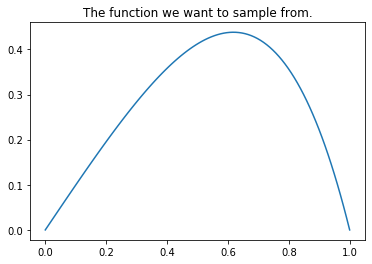

In [0]:
# Defnie the function we want to sample from
l = lambda x: x * (1-x) * np.exp(x)

# Plot the function
domain = np.linspace(0,1,100)
plt.plot(domain, l(domain))
plt.title("The function we want to sample from.")
plt.show()

It looks like a beta function might do the job nicely.

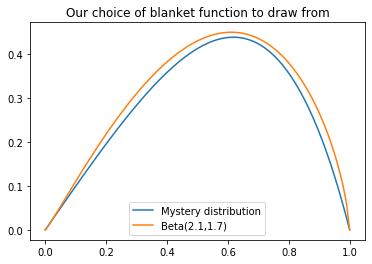

In [0]:
a,b = 2.1,1.7
be = beta(a,b).pdf

plt.plot(domain, l(domain),label="Mystery distribution")
plt.plot(domain, be(domain)/3.3,label="Beta({},{})".format(a,b))
plt.legend()
plt.title("Our choice of blanket function to draw from")
plt.show()

Our function of choice is Beta(2.1,1.7) / 3.3

In [0]:
be = beta(2.1,1.7)

def is_under(x,y):
  return y < l(x)

def draw(n):
  """ Draws a sample from the given distribution using rejection sampling """
  x = be.rvs(2*n)
  y = np.random.random(2*n) * be.pdf(x) / 3.3

  samples = x[np.where(is_under(x,y))[0]]
  return samples[:n]

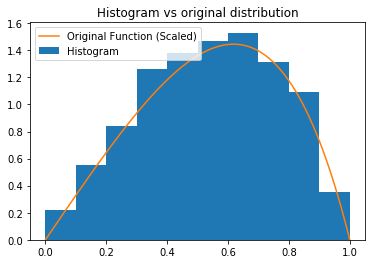

In [216]:
samples = draw(1000)

plt.hist(samples,range=(0,1),density=True, label="Histogram")
plt.plot(domain, 3.3 * l(domain), label="Original Function (Scaled)")
plt.title("Histogram vs original distribution")
plt.legend()
plt.show()